通过多项式拟合来交互地探索这些概念

In [1]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

使用以下三阶多项式来生成训练和测试数据的标签：
$$
y=5+1.2 x-3.4 \frac{x^{2}}{2 !}+5.6 \frac{x^{3}}{3 !}+\epsilon \text { where } \epsilon \sim \mathcal{N}\left(0,0.1^{2}\right)
$$

In [6]:
max_degree = 20 # 特征数
n_train, n_test = 100, 100
true_w = np.zeros(max_degree)
true_w[0: 4] = np.array([5, 1.2, -3.4, 5.6])

# 随机生成(n_train + n_test)个样本
features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)

# 对所有样本特征依次求0-19次方
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1)) 

for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1) # math.gamma() - 阶乘函数

labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [7]:
ture_w, features, poly_features, labels = [
    torch.tensor(x, dtype=torch.float32)
    for x in [true_w, features, poly_features, labels]
]

features[: 2], poly_features[: 2, :], labels[: 2]

(tensor([[0.0532],
         [1.3146]]),
 tensor([[1.0000e+00, 5.3215e-02, 1.4159e-03, 2.5116e-05, 3.3413e-07, 3.5561e-09,
          3.1540e-11, 2.3977e-13, 1.5949e-15, 9.4301e-18, 5.0182e-20, 2.4277e-22,
          1.0766e-24, 4.4068e-27, 1.6751e-29, 5.9425e-32, 1.9764e-34, 6.1867e-37,
          1.8290e-39, 5.1231e-42],
         [1.0000e+00, 1.3146e+00, 8.6407e-01, 3.7863e-01, 1.2444e-01, 3.2716e-02,
          7.1681e-03, 1.3462e-03, 2.2121e-04, 3.2310e-05, 4.2475e-06, 5.0761e-07,
          5.5608e-08, 5.6232e-09, 5.2801e-10, 4.6275e-11, 3.8020e-12, 2.9400e-13,
          2.1472e-14, 1.4856e-15]]),
 tensor([4.9553, 5.6475]))

实现一个函数来评估模型在给定数据集上的损失

In [8]:
def evaluate_loss(net, data_iter, loss):
    """评估给定数据集上模型的损失"""
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

定义训练函数

In [13]:
def train(train_features, test_features, train_labels, test_labels, num_epochs=400):
    loss = nn.MSELoss()
    input_shape = train_features.shape[-1]
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1, 1)), 
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1, 1)), 
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr = 0.01)
    
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0: # 每20论绘图一次
            animator.add(epoch + 1, 
                         (evaluate_loss(net, train_iter, loss),
                          evaluate_loss(net, test_iter, loss)))
    print('weight: ', net[0].weight.data.numpy())

三阶多项式函数拟合（正态）

weight:  [[ 5.0144224  1.2681937 -3.475994   5.369141 ]]


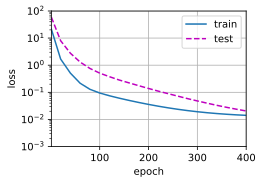

In [15]:
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
     labels[:n_train], labels[n_train:])

线性函数拟合（欠拟合）

weight:  [[3.3636858 3.8514416]]


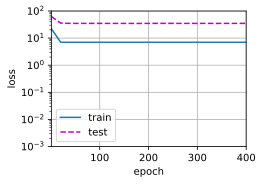

In [16]:
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
     labels[:n_train], labels[n_train:])

高阶多项式函数拟合（过拟合）

weight:  [[ 4.9290676e+00  1.5718981e+00 -3.0819359e+00  3.9074199e+00
  -1.8798215e+00  1.3181820e+00 -6.5208316e-01  2.7685004e-01
   2.5775218e-02  1.8123040e-01  3.2334045e-02 -8.5899152e-02
  -2.1816662e-01  1.4601466e-01  7.2192535e-02 -7.0064053e-02
  -1.9055687e-01  2.1048531e-01 -4.9298524e-05  2.4441108e-02]]


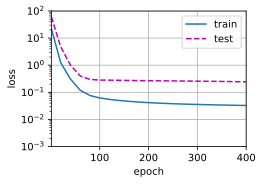

In [20]:
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:])